In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
#Création de structure de graphe    
def create_graph(nodes , edges):
    G = nx.Graph()
    G.add_nodes_from(range(nodes))
    G.add_edges_from(edges)
    return G

In [3]:
def afficher_graphe(G , title="Graphe"):
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=16, font_color='black', edge_color='gray')
    plt.title(title)
    plt.show()

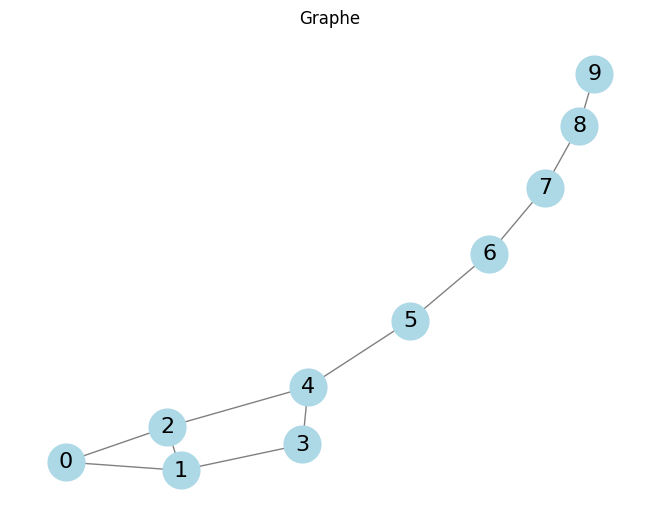

In [4]:
#Test de la fonction create_graph :éxécution 
G = create_graph(10, [(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)])
#Affichage du graphe
afficher_graphe(G)

In [5]:
def welsh_powell(G):
    nodes = sorted(G.nodes(), key=lambda x: G.degree(x), reverse=True)
    colors = {}  
    for node in nodes:
        used_colors = {colors.get(neighbor) for neighbor in G.neighbors(node) if neighbor in colors}
        color = 1
        while color in used_colors:
            color += 1
        colors[node] = color
    return colors , len(set(colors.values()))

In [6]:
colors , chromatic_number = welsh_powell(G)


In [7]:
def afficher_graphe_colorie(G, colors, title="Graphe colorié"):
    pos = nx.spring_layout(G)
    color_map = [colors[node] for node in G.nodes()]
    nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=700, font_size=16, font_color='black', edge_color='gray')
    plt.title(title)
    plt.show()

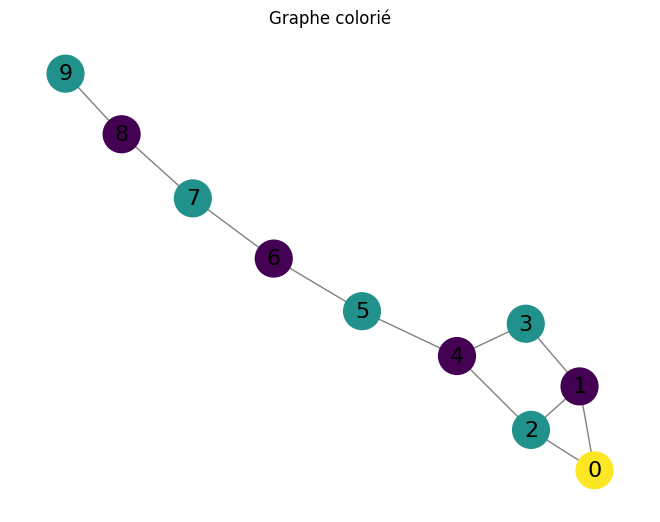

In [8]:
afficher_graphe_colorie(G, colors)

Exemples à tester : 

Créer et tester au moins 5 graphes :
o Un petit graphe manuel (6-8 sommets)
o Trois autres graphes de taille plus grande avec spécificités différentes selon l'algorithme choisi (avec ou sans cycles, avec des degrés de sommets similaires ou différentes, avec des pondérations variées positives et négatives si nécessaire...)
o Un graphe généré automatiquement (optionnel mais recommandé)
• Vérifier les résultats (cohérence des chemins, poids, nombre de couleurs…)
• Afficher les graphes et annoter les résultats dans le rapport.


1. si C est un cycle alors : γ (C) = 2 si C est un cycle pair
 y(C) = 3 si C est un cycle impair
2. γ (Kn) = n
3. Si G est biparti, alors γ (G) = 2. En particulier si T est un arbre, alors γ (T) = 2
4. Line graph ou graphe adjoint
5. Transport de produits chimiques incompatibles (Exemple problématique)

Exemple 3 : 
3. Si G est biparti, alors γ (G) = 2. En particulier si T est un arbre, alors γ (T) = 2


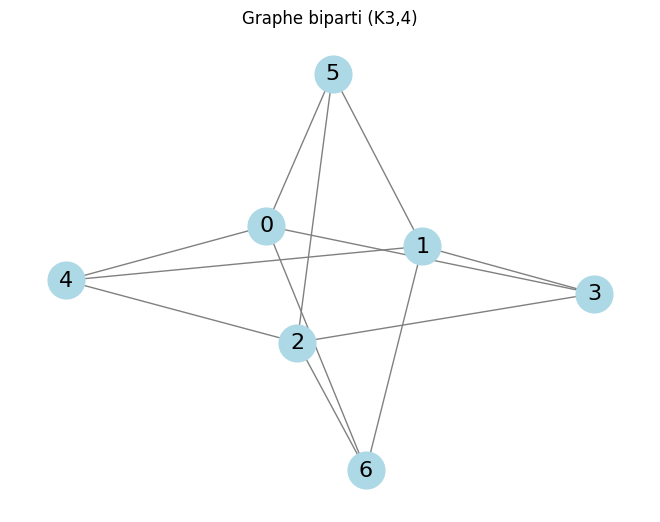

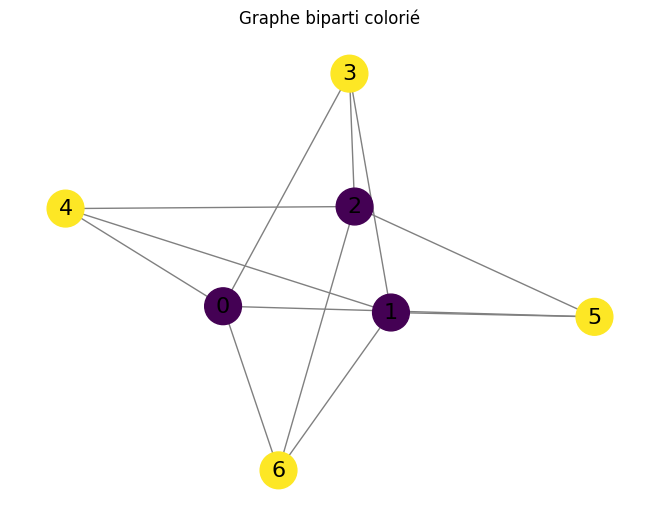

In [31]:
# Bipartite graph: Complete bipartite K_{3, 4}
G_bipartite = nx.complete_bipartite_graph(3, 4)

# Test
afficher_graphe(G_bipartite, "Graphe biparti (K3,4)")
colors_bipartite, chromatic_bipartite = welsh_powell(G_bipartite)
afficher_graphe_colorie(G_bipartite, colors_bipartite, "Graphe biparti colorié")


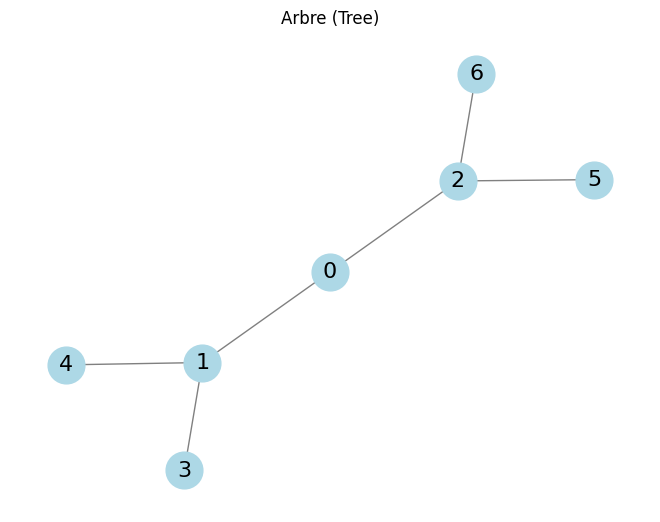

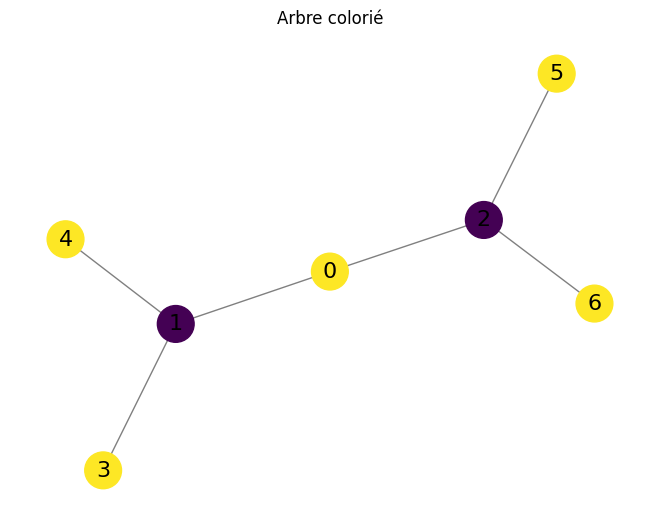

In [39]:
# Tree graph (binary-like)
edges_tree = [(0, 1), (0, 2), (1, 3), (1, 4), (2, 5), (2, 6)]
G_tree = create_graph(7, edges_tree)

# Test
afficher_graphe(G_tree, "Arbre (Tree)")
colors_tree, chromatic_tree = welsh_powell(G_tree)
afficher_graphe_colorie(G_tree, colors_tree, "Arbre colorié")


En résumé, l'experience conforme au theorie:

-Tout graphe biparti est 2-coloriable, donc son nombre chromatique γ(G) vaut 2.

-Tout arbre étant nécessairement biparti, il possède la même propriété ; ainsi, pour n’importe quel arbre T, on obtient γ(T) = 2.

Autrement dit, deux couleurs suffisent toujours pour colorier sans conflit les sommets d’un graphe biparti ou d’un arbre.

Exemple 4 : Line graph ou graphe adjoint

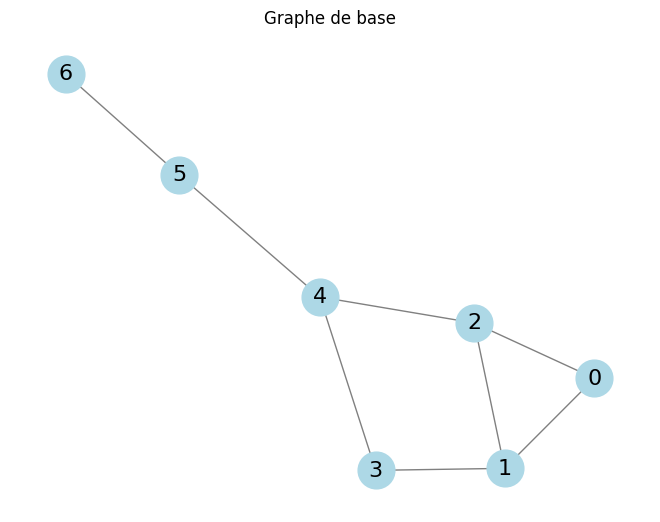

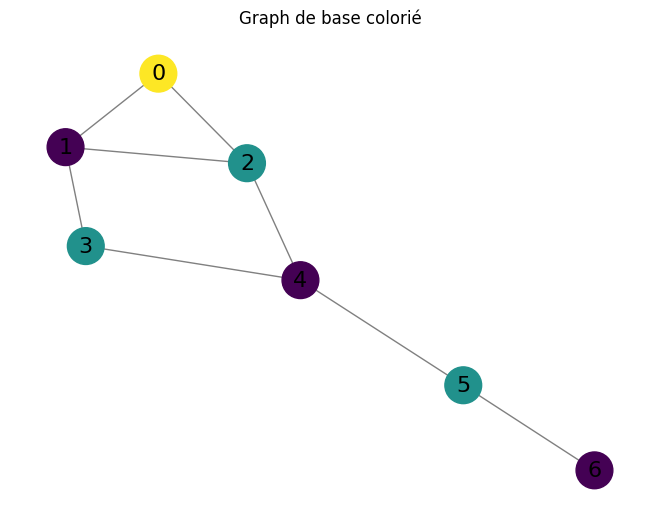

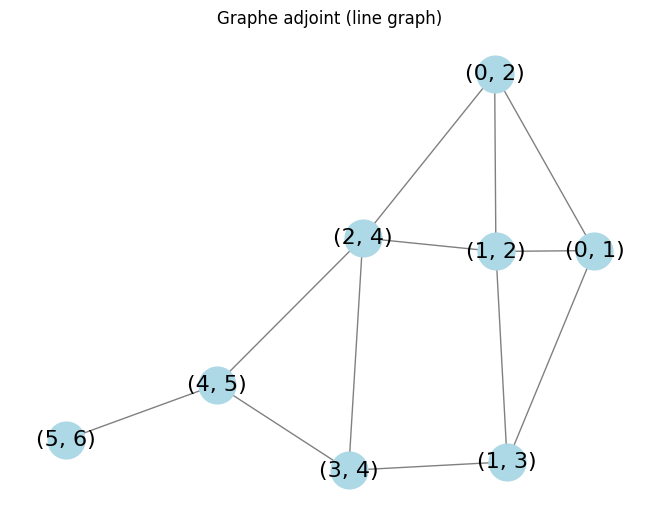

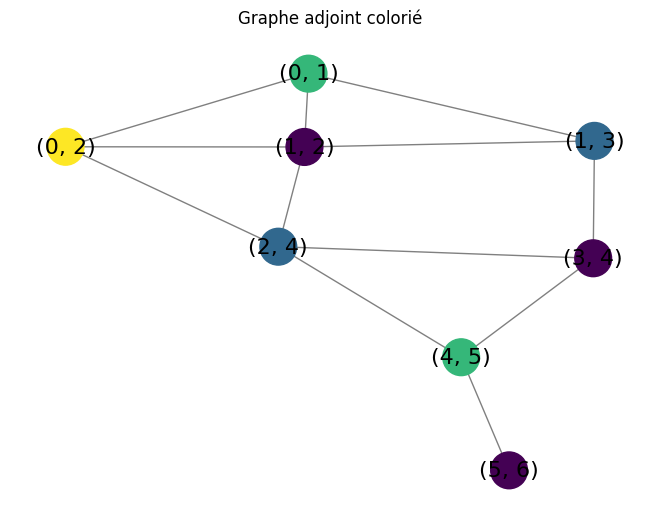

In [46]:
# Graphe de base G
edges_base = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4), (4, 5), (5, 6)]
G_base = create_graph(7, edges_base)
afficher_graphe(G_base, "Graphe de base")
colors_line, chromatic_line = welsh_powell(G_base)
afficher_graphe_colorie(G_base, colors_line, "Graph de base colorié")

# Graphe adjoint (line graph)
G_line = nx.line_graph(G_base)
afficher_graphe(G_line, "Graphe adjoint (line graph)")

# Coloration du graphe adjoint
colors_line, chromatic_line = welsh_powell(G_line)
afficher_graphe_colorie(G_line, colors_line, "Graphe adjoint colorié")


In [9]:
# Amélioration de l'algorithme de Welsh et Powell pour avoir le nombre de couleurs minimum :
!pip install pulp


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, value


In [11]:
def ilp_coloring(G):
    nodes = list(G.nodes())
    edges = list(G.edges())
    max_colors = len(nodes)  # Borne supérieure : nombre de sommets
    
    # Créer le problème ILP
    prob = LpProblem("Graph_Coloring", LpMinimize)
    
    # Variables
    # x[v,k] = 1 si le nœud v a la couleur k
    x = {(v, k): LpVariable(f"x_{v}_{k}", 0, 1, LpBinary) for v in nodes for k in range(max_colors)}
    # w = nombre de couleurs utilisées
    w = LpVariable("w", 0, max_colors)
    
    # Objectif : minimiser le nombre de couleurs
    prob += w
    
    # Contraintes
    # 1. Chaque nœud a exactement une couleur
    for v in nodes:
        prob += lpSum(x[v, k] for k in range(max_colors)) == 1, f"One_color_{v}"
    
    # 2. Nœuds adjacents ont des couleurs différentes
    for u, v in edges:
        for k in range(max_colors):
            prob += x[u, k] + x[v, k] <= 1, f"Diff_color_{u}_{v}_{k}"
    
    # 3. w >= k si la couleur k est utilisée
    for k in range(max_colors):
        for v in nodes:
            prob += w >= (k + 1) * x[v, k], f"Color_used_{v}_{k}"
    
    # Résoudre
    prob.solve()
    
    # Extraire la coloration
    colors = {}
    for v in nodes:
        for k in range(max_colors):
            if value(x[v, k]) > 0.5:
                colors[v] = k + 1
                break
    
    # Nombre chromatique
    chromatic_number = int(value(w))
    return colors, chromatic_number

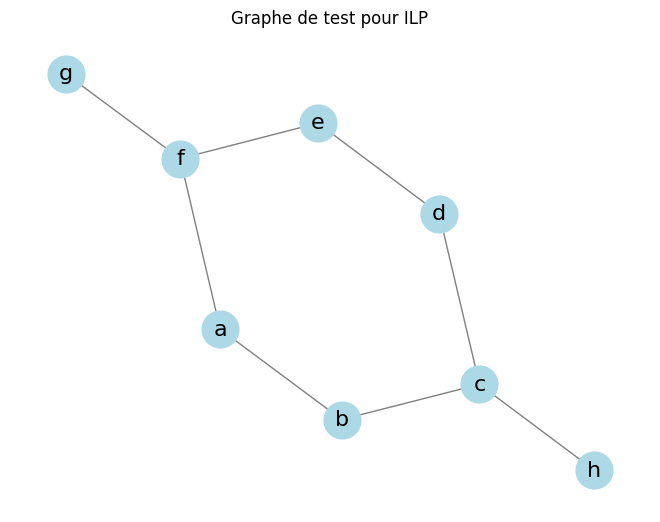

In [12]:
G = nx.Graph()
G.add_nodes_from(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
G.add_edges_from([('a', 'b'), ('b', 'c'), ('c', 'd'), ('d', 'e'), ('e', 'f'), ('f', 'a'), ('f', 'g'), ('c', 'h')])
afficher_graphe(G, "Graphe de test pour ILP")

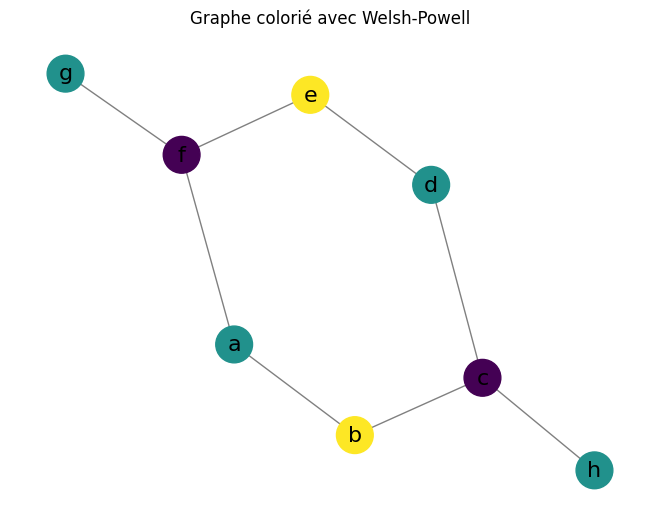

In [13]:
colors  , chromatic_number = welsh_powell(G)
# Affichage des couleurs attribuées aux nœuds
afficher_graphe_colorie(G, colors, "Graphe colorié avec Welsh-Powell")

Coloration ILP : {'a': 1, 'b': 2, 'c': 1, 'd': 2, 'e': 1, 'f': 2, 'g': 1, 'h': 2}


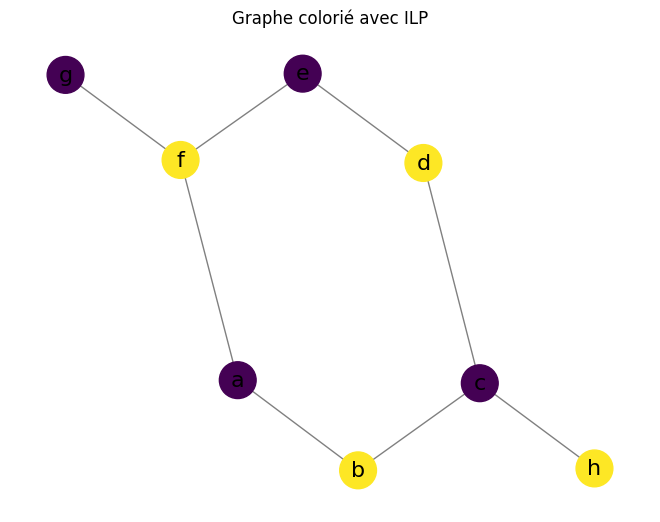

In [14]:
# test avec l'algorithme ILP
colors_ilp, chromatic_number = ilp_coloring(G)
print("Coloration ILP :", colors_ilp)
afficher_graphe_colorie(G, colors_ilp, "Graphe colorié avec ILP")